### Detect Level Ice Tests

##### NOTES for NILS

We're pulling our level ice theory from Von Abedyll et al. and Rabenstein et al., which were designed for very small data granularity. While that is true of IS2 as well, there are actually relatively few inter-return distances that are less than 100 meters. Interpolating the IS2 measurements to 100m segments results in an order of magnitude more points. **This means that the calculated mask has a much finer level of detail in parsing what ice is level than the IS2 data can always resolve.**

Questions to consider: 

1. Do we need this level of granularity? If not, can we adapt the level_ice theory (the gradient threshold perhaps) so that we can deal more directly with the ICESat-2 measurements?
    - reasoning behind this: when interpolated to 100m, there are many segments that are "level" and "non-level" between two actual IS2 returns-- how would we decided to assign the IS2 returns in this case? 

2. Can we accomplish our analysis reasonably by downscaling everything to 100m? 
    - Would need some measure of the interpolation accuracy, perhaps some validation with another data source? 
    - If not, can we think about representing level versus non-level ice as relative fractions within each grid cell/buoy bounding polygon?
        - we'd need to carry around the lat/lon/data for IS2 and the 100m lat/lon/mask for level ice for a while (sort each into bounding polygons separately?) 

3. If we want to continue using the theory (VA and Rabenstein), what's the best way to project the 100m interpolated mask back out the the real lat/lon? How should we make the decisions about point-to-point intervals that have level and non-level segments in between them? 


### Import Library and define functions

In [35]:
import xarray as xr
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import lagrange

Set up some testing data

In [3]:
file = '/glade/scratch/mollyw/external_data/ICESat-2/freeboard/2019.01.01/ATL10-01_20190101005132_00550201_005_02.h5'
track = 'gt1r'

Define functions

In [4]:
def read_track(file, track):
    with h5py.File(file, mode='r') as f:
        latvar = f['/%s/freeboard_beam_segment/beam_freeboard/latitude' % track]
        latitude = latvar[:]
    
        # access the longitude
        lonvar = f['/%s/freeboard_beam_segment/beam_freeboard/longitude' % track]
        longitude = lonvar[:]

        # access the freeboard values 
        datavar = f['/%s/freeboard_beam_segment/beam_freeboard/beam_fb_height' % track]
        data = datavar[:]

        # access the freeboard uncertainty
        unc_var = f['/%s/freeboard_beam_segment/beam_freeboard/beam_fb_sigma' % track]
        unc = unc_var[:]

        # access the open ocean mask
        mask_var = f['/%s/freeboard_beam_segment/height_segments/height_segment_ssh_flag' % track]
        mask = mask_var[:]

        # access the surface type classification
        surf_var = f['/%s/freeboard_beam_segment/height_segments/height_segment_type' % track]
        surf = surf_var[:]

        #handle FillValue
        _FillValue = datavar.attrs['_FillValue']
        data[data == _FillValue] = np.nan
        unc[unc == _FillValue] = np.nan

        # collect time information
        timevar = f['/%s/freeboard_beam_segment/delta_time' % track]
        time = timevar[:]

        return data, latitude, longitude


In [5]:
def haversine_distance(x1, x2, y1, y2):

    dist = 2*np.arcsin(np.sqrt(np.sin((x1 - y1)/2)**2 +
                               np.cos(x1)*np.cos(y1)*np.sin((x2-y2)/2)**2))
    return dist

In [6]:
def latlon2dist(data, latitude, longitude):
        x_interp = []
        for i in range(0, len(data)-1):
                x1 = latitude[i]
                y1 = longitude[i]

                x2 = latitude[i+1]
                y2 = longitude[i+1]

                dist = 1000 * haversine_distance(x1, x2, y1, y2)
                x_interp.append(dist)

        distances = np.cumsum(x_interp)
        distances = np.insert(distances, 0, 0)

        return distances

In [7]:
def interp_100m(data, latitude, longitude, distances):

    x_new = np.arange(0, distances[-1], 100)

    new_data = np.interp(x_new, distances, data)
    new_lats = np.interp(x_new, distances, latitude)
    new_lons = np.interp(x_new, distances, longitude)

    return new_data, new_lats, new_lons

In [25]:
def create_mask(data):

    
    # calculate the gradient of the data
    gradient = np.gradient(data)

    # create mask 
    mask = []
    for x in range(0, len(gradient)):
        # if the data was NaN, the mask is NaN
        if np.isnan(gradient[x]):
            mask.append(np.nan)
        # if the gradient is greater than the threshold, assign it 0 (False)
        elif abs(gradient[x]) > 0.04:
            mask.append(0)
        # else, assign the mask 1 (True)
        else:
            mask.append(1)

    return mask 
    # 

In [26]:
def detect_level_ice(data, latitude, longitude):
    
    distances = latlon2dist(data, latitude, longitude)

    new_data, new_lats, new_lons = interp_100m(data, latitude, longitude, distances)

    mask = create_mask(new_data)

    return mask, new_lats, new_lons

### Demonstrate test case

Read track

In [9]:
data, lat, lon = read_track(file, track)

Deploy function

In [27]:
mask, nlat, nlon = detect_level_ice(data, lat, lon)

Plot mask

(I will make this an actual map soon!)

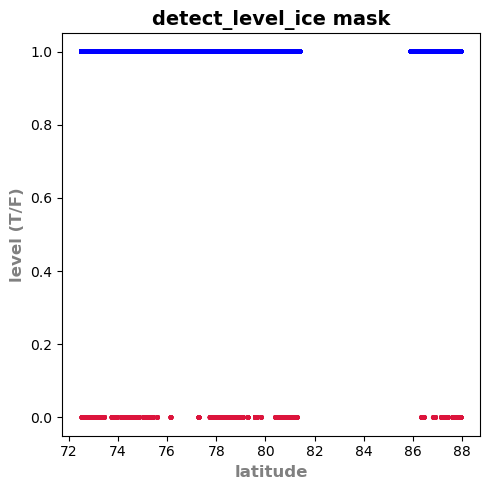

In [42]:
fig = plt.figure(figsize=(5,5))
cmap = mpl.colors.ListedColormap(['crimson', 'blue'])
plt.scatter(nlat, mask, s = 5, c = mask, cmap = cmap, facecolor=None)
# plt.colorbar()

plt.xlabel('latitude', fontweight='bold', fontsize=12, color = 'grey')
plt.ylabel('level (T/F)', fontweight='bold', fontsize=12, color = 'grey')
plt.title('detect_level_ice mask', fontweight='bold', fontsize=14)

plt.tight_layout()